In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Activation, Dropout,Flatten,Embedding
from keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D, Bidirectional, LSTM, GRU
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,Nadam,RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import pickle
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Dataset Loading

In [2]:
df_train = pd.read_csv('../input/nlp-competition-cuet-ete-day-2022/train.csv')
df_test = pd.read_csv('../input/nlp-competition-cuet-ete-day-2022/test.csv')

### Train Dataset Processing

In [3]:
df_train.head()

,Id,headlines,category
0,0,উত্তর প্রদেশে প্রিয়াংকার ইমেজ ব্যর্থ,0
1,1,১০০০ বিড়াল অতিথিকে নিয়ে বিয়ে করলেন কানাডিয়া...,1
2,2,মিসর ছেড়ে চেচনিয়ার হয়ে খেলবেন সালাহ!,0
3,3,আলেপ্পোয় বিমান হামলা যুদ্ধাপরাধের শামিল,0
4,4,"সিয়াটলে চুরি হওয়া বিমানটি বিধ্বস্ত, চালক ছিলেন...",0


In [4]:
df_train.describe()

,Id,category
count,48508.000000,48508.000000
mean,24253.500000,0.125052
std,14003.197766,0.330781
min,0.000000,0.000000
25%,12126.750000,0.000000
50%,24253.500000,0.000000
75%,36380.250000,0.000000
max,48507.000000,1.000000


<AxesSubplot:xlabel='category', ylabel='count'>

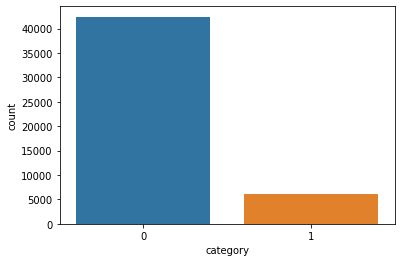

In [5]:
sns.countplot(df_train.category)

In [6]:
df_train.isnull().sum()

Id           0
headlines    3
category     0
dtype: int64

In [7]:
df_train = df_train.dropna()

In [8]:
df_train.category.value_counts()

0    42439
1     6066
Name: category, dtype: int64

### Functions for preprocessing text 

In [9]:
def remove_pattern(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text


punc = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰✌�￰৷￰'''
def remove_punc(text):
    cleaned = ""
    for char in text:
        if char not in punc:
            cleaned += char
    return cleaned

In [10]:
# banstop =pd.read_excel('../input/banstopwords/banstop.xlsx')
# stp_words = banstop['words'].tolist()

In [11]:
# def remove_stopwords(text):
#     text = str(text)
#     words = text.split()
#     l = [word for word in words if word not in stp_words]
#     cleaned = ' '.join(str(x) for x in l)
#     return cleaned

In [12]:
def preprocess(text):
    cleaned = remove_punc(remove_pattern(text))
#     final = remove_stopwords(cleaned)
    return cleaned

In [13]:
df_train['cleaned'] = df_train['headlines'].apply(preprocess)

In [14]:
df_train.head()

,Id,headlines,category,cleaned
0,0,উত্তর প্রদেশে প্রিয়াংকার ইমেজ ব্যর্থ,0,উত্তর প্রদেশে প্রিয়াংকার ইমেজ ব্যর্থ
1,1,১০০০ বিড়াল অতিথিকে নিয়ে বিয়ে করলেন কানাডিয়া...,1,বিড়াল অতিথিকে নিয়ে বিয়ে করলেন কানাডিয়ান দম...
2,2,মিসর ছেড়ে চেচনিয়ার হয়ে খেলবেন সালাহ!,0,মিসর ছেড়ে চেচনিয়ার হয়ে খেলবেন সালাহ
3,3,আলেপ্পোয় বিমান হামলা যুদ্ধাপরাধের শামিল,0,আলেপ্পোয় বিমান হামলা যুদ্ধাপরাধের শামিল
4,4,"সিয়াটলে চুরি হওয়া বিমানটি বিধ্বস্ত, চালক ছিলেন...",0,সিয়াটলে চুরি হওয়া বিমানটি বিধ্বস্ত চালক ছিলেন ...


### Removing low length data 

In [15]:
df_train['length'] = df_train['cleaned'].str.split().str.len()
df_train = df_train.loc[df_train['length']>=2]

### Train Dataset summary

In [16]:
def show_summary(dataset):

    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category ==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Headlines:{}".format(len(list(dataset[dataset.category==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

documents,words,u_words,class_names = show_summary(df_train)


Class Name :  0
Number of Headlines:42370
Number of Words:243458
Number of Unique Words:34470
Most Frequent Words:

না	1905
ও	1406
নিয়ে	1369
নিহত	1137
হবে	989
নতুন	989
থেকে	911
সঙ্গে	722
আজ	685
বাংলাদেশ	683

Class Name :  1
Number of Headlines:6055
Number of Words:45582
Number of Unique Words:14992
Most Frequent Words:

এই	583
না	321
থেকে	275
করে	221
জানেন	171
কি	170
ভাইরাল	142
এক	134
ও	126
ভিডিও	125
Total Number of Unique Words:41756


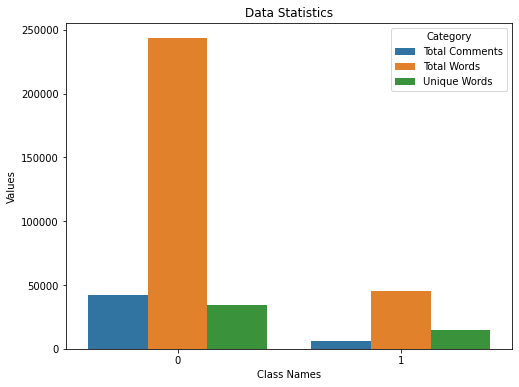

In [17]:
data_matrix = pd.DataFrame({'Total Comments':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names);

### Frequency length distribution

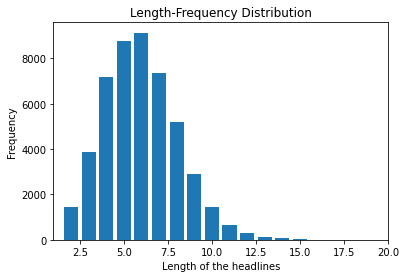

Maximum Length of a headlines: 21
Minimum Length of a headlines: 2
Average Length of a headlines: 6.0


In [18]:
frequency = dict()
for i in df_train.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values())
plt.xlim(1, 20)

plt.xlabel('Length of the headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a headlines: {max(df_train.length)}")
print(f"Minimum Length of a headlines: {min(df_train.length)}")
print(f"Average Length of a headlines: {round(np.mean(df_train.length),0)}")


### Tokenizing text

In [19]:
max_words = 50000
tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(df_train['cleaned'])

word_counts = tokenizer.word_counts
word_docs = tokenizer.word_docs
word_index = tokenizer.word_index
document_count = tokenizer.document_count

print(len(word_counts))

41764


In [20]:
with open('tokenizer_7th.pickle','wb') as f:
    pickle.dump(tokenizer,f,protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
sequences = tokenizer.texts_to_sequences(df_train.cleaned)
word_index = tokenizer.word_index

max_len = 20
corpus = pad_sequences(sequences, value=0, padding='post', maxlen= max_len)

In [22]:
for i in range(5):
    print(f'Headline: {df_train.cleaned[i]} \n Sequence: {sequences[i]} \n padded sequence: \n {corpus[i]} \n')


Headline: উত্তর প্রদেশে প্রিয়াংকার ইমেজ ব্যর্থ 
 Sequence: [330, 3908, 4912, 13566, 417] 
 padded sequence: 
 [  330  3908  4912 13566   417     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] 

Headline:  বিড়াল অতিথিকে নিয়ে বিয়ে করলেন কানাডিয়ান দম্পতি 
 Sequence: [3669, 13567, 4, 2002, 39, 13568, 1226] 
 padded sequence: 
 [ 3669 13567     4  2002    39 13568  1226     0     0     0     0     0
     0     0     0     0     0     0     0     0] 

Headline: মিসর ছেড়ে চেচনিয়ার হয়ে খেলবেন সালাহ 
 Sequence: [4195, 354, 19338, 71, 1278, 1559] 
 padded sequence: 
 [ 4195   354 19338    71  1278  1559     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] 

Headline: আলেপ্পোয় বিমান হামলা যুদ্ধাপরাধের শামিল 
 Sequence: [13569, 106, 42, 4196, 4913] 
 padded sequence: 
 [13569   106    42  4196  4913     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] 

Headline: সিয়াটলে চুরি হওয়া বি

In [23]:
y_train = df_train['category']
X_train = corpus

### Model Defination

In [24]:
import keras.backend as K
K.clear_session()

embedding_dim = 64

#BiGRU
bigru_in = Input(shape=(max_len,))
bigru_em_layer = Embedding(max_words,embedding_dim)(bigru_in)
bigru_layer_1 = Bidirectional(GRU(32,dropout= 0.1))(bigru_em_layer)
bigru_dense_layer_1 = Dense(32,activation='relu')(bigru_layer_1)
bigru_flatten1 = Flatten()(bigru_dense_layer_1)
bigru_out = Dense(1,activation = 'sigmoid')(bigru_flatten1)
bigru_model = Model(inputs=bigru_in, outputs=bigru_out)

#BiLSTM
bilstm_in = Input(shape=(max_len,))
bilstm_em_layer = Embedding(max_words,embedding_dim)(bilstm_in)
bilstm_layer_1 = Bidirectional(LSTM(32,dropout= 0.1))(bilstm_em_layer)
bilstm_dense_layer_1 = Dense(32,activation='relu')(bilstm_layer_1)
bilstm_flatten1 = Flatten()(bilstm_dense_layer_1)
bilstm_out = Dense(1,activation = 'sigmoid')(bilstm_flatten1)
bilstm_model = Model(inputs=bilstm_in, outputs=bilstm_out)

#BiGRU+CNN
hybrid_in = Input(shape=(max_len,))
hybrid_em_layer = Embedding(max_words,embedding_dim)(hybrid_in)
gru_Layer = Bidirectional(GRU(32,return_sequences=True))(hybrid_em_layer)
hybrid_conv1 = Conv1D(32,2,activation='relu')(gru_Layer)
hybrid_pool1 = MaxPooling1D(2)(hybrid_conv1)
hybrid_flat1 = Flatten()(hybrid_pool1)
hybrid_out = Dense(1, activation='sigmoid')(hybrid_flat1)
gru_cnn = Model(inputs=hybrid_in, outputs=hybrid_out)

#BiLSTM+CNN
blcnn_in = Input(shape=(max_len,))
blcnn_em_layer = Embedding(max_words,embedding_dim)(blcnn_in)
bl_layer = Bidirectional(LSTM(32,return_sequences=True))(blcnn_em_layer)
blcnn_conv1 = Conv1D(32,2,activation='relu')(bl_layer)
blcnn_pool1 = MaxPooling1D(2)(blcnn_conv1)
blcnn_flat1 = Flatten()(blcnn_pool1)
blcnn_out = Dense(1, activation='sigmoid')(blcnn_flat1)
lstm_cnn = Model(inputs=blcnn_in, outputs=blcnn_out)


2022-10-21 18:40:15.554341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 18:40:15.656933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 18:40:15.657840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 18:40:15.659567: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [25]:
fusion_layer = keras.layers.concatenate([bigru_model.output, bilstm_model.output,gru_cnn.output,lstm_cnn.output],name = 'Lately-Fused_4')
fused_dense = Dense(16, activation='relu')(fusion_layer)
fused_flatten = Flatten()(fused_dense)
fused_out = Dense(1, activation='sigmoid')(fused_flatten)

In [26]:
Lf4_model = Model(inputs = [bigru_model.input, bilstm_model.input,gru_cnn.input,lstm_cnn.input], outputs=fused_out,name = "LF_Trio")
Lf4_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
Lf4_model.summary()

Model: "LF_Trio"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
____________________________________________________________________________________________

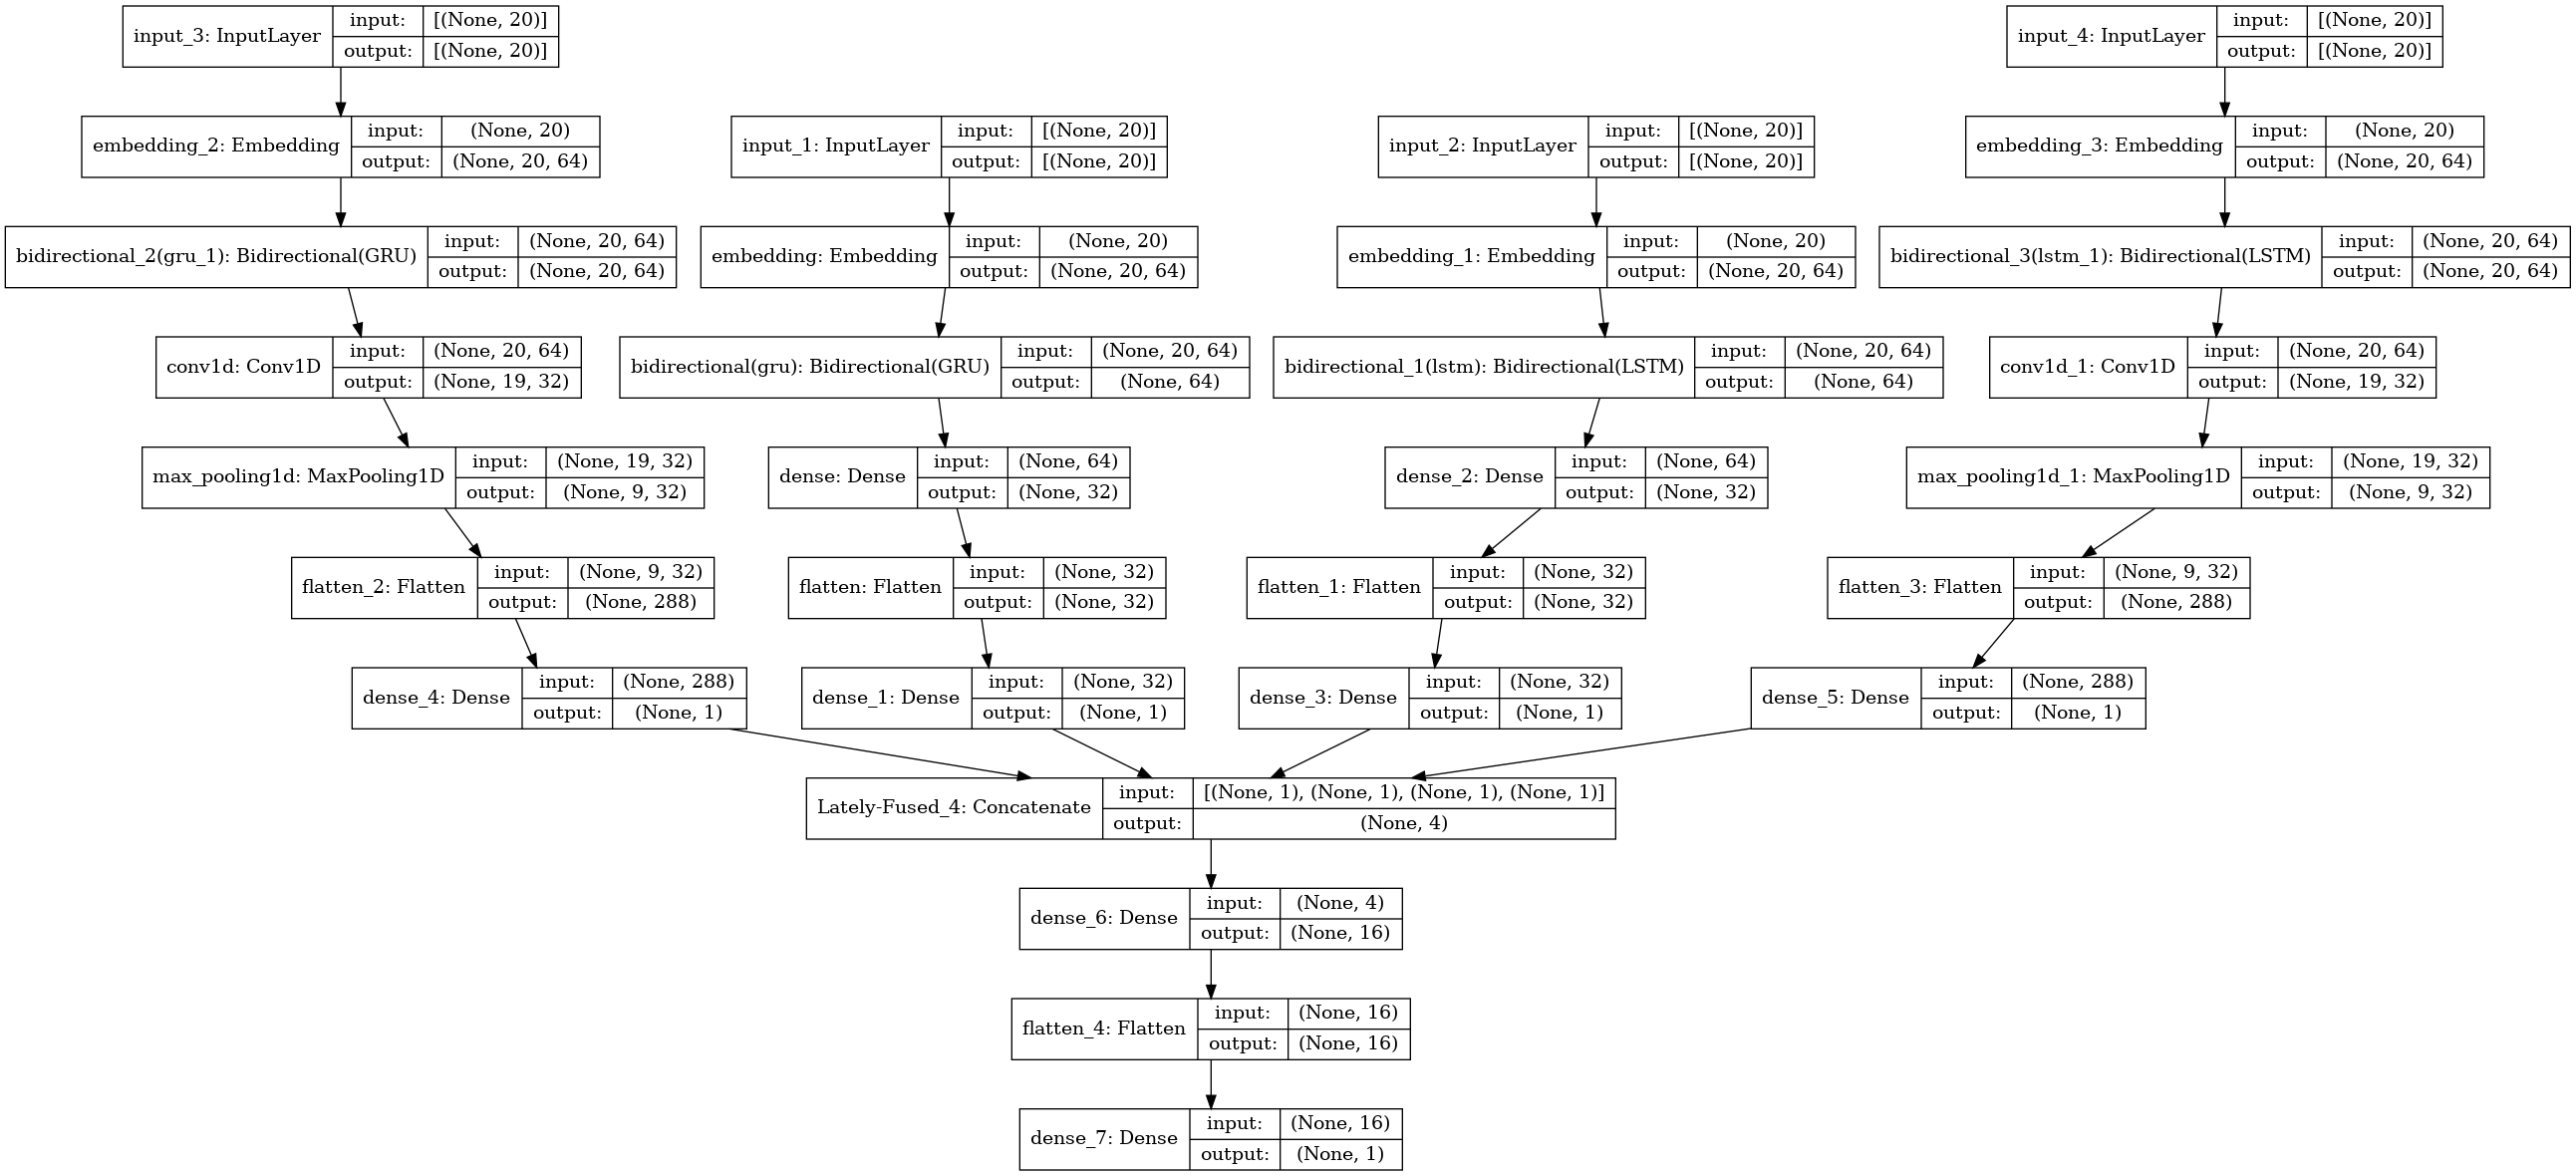

In [28]:
plot_model(Lf4_model, to_file='LF4_model.png', show_shapes=True, show_layer_names=True)

### Defining custom callbacks

In [29]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
early_stp = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=0,
    mode="auto",
)
model_check = ModelCheckpoint('LF_Trio_stp.h5', monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_lst = [early_stp,model_check]

In [30]:
history = Lf4_model.fit([X_train,X_train,X_train,X_train],
                          y_train,
                          epochs = 10,
                          batch_size = 64,
                          verbose = 1,
                          validation_split = 0.1,
                          callbacks = callback_lst)

2022-10-21 18:40:21.528274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-10-21 18:40:32.929277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


681/681 [==============================] - 35s 25ms/step - loss: 0.3543 - accuracy: 0.8793 - val_loss: 0.2235 - val_accuracy: 0.9234

Epoch 00001: val_accuracy improved from -inf to 0.92339, saving model to LF_Trio_stp.h5
Epoch 2/10
681/681 [==============================] - 14s 21ms/step - loss: 0.1517 - accuracy: 0.9490 - val_loss: 0.1633 - val_accuracy: 0.9383

Epoch 00002: val_accuracy improved from 0.92339 to 0.93826, saving model to LF_Trio_stp.h5
Epoch 3/10
681/681 [==============================] - 14s 21ms/step - loss: 0.0515 - accuracy: 0.9851 - val_loss: 0.1922 - val_accuracy: 0.9393

Epoch 00003: val_accuracy improved from 0.93826 to 0.93929, saving model to LF_Trio_stp.h5
Epoch 4/10
681/681 [==============================] - 14s 20ms/step - loss: 0.0221 - accuracy: 0.9951 - val_loss: 0.2205 - val_accuracy: 0.9354

Epoch 00004: val_accuracy did not improve from 0.93929
Epoch 5/10
681/681 [==============================] - 15s 22ms/step - loss: 0.0127 - accuracy: 0.9969 - va

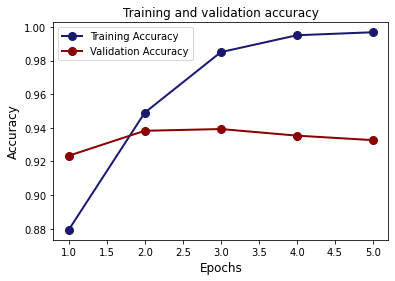

In [31]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

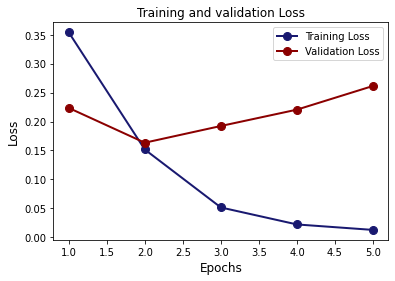

In [32]:
plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation Loss',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend(['Training Loss','Validation Loss'])

### Function for predicting Output

In [33]:
best_model = keras.models.load_model('./LF_Trio_stp.h5')
def predict_res(sample):
    processed_text = preprocess(sample)
    with open('./tokenizer_7th.pickle', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
    seq= loaded_tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(seq, value=0,padding='post', maxlen= 20)
    pred = best_model.predict([padded,padded,padded,padded])[0]
    pred_f = (pred>0.5).astype('int')
    return pred_f[0]

In [34]:
predict_res('এই গ্রামের সব সারমেয় কোটিপতি')

1

In [35]:
predict_res('শেখ হাসিনার ভূয়সী প্রশংসা')

0

In [36]:
df_test.head(10)

,Id,headlines
0,0,"মেসি-রোনাল্ডোর দিন শেষ, ব্যালন ডিঅর পাচ্ছেন মড..."
1,1,রানি মুখার্জির ফেরা নিশ্চিত হল
2,2,মোদি মিথ্যাবাদী : গগৈ
3,3,"সন্ত্রাস, দুর্নীতিতে জড়িত কাউকে ছাড় দেয়া হবে ন..."
4,4,আবারো শেষের নায়ক রামোস
5,5,আর্জেন্টিনাকে হারিয়েও ব্রাজিলের আক্ষেপ
6,6,সিবিআইপ্রধানের বাড়ির সামনে থেকে ৪ সন্দেহভাজন গ...
7,7,এই গ্রামের সব সারমেয় কোটিপতি
8,8,আন্তঃবিশ্ববিদ্যালয় ক্রিকেটে চ্যাম্পিয়ন রাবি
9,9,কাল আরব আমিরাত যাচ্ছেন সেনাপ্রধান


### Applying prediction function on test dataset

In [37]:
df_test['category'] = df_test['headlines'].apply(predict_res)

In [38]:
df_test.category.value_counts()

0    10779
1     1348
Name: category, dtype: int64

### Generating submission file in csv format

In [39]:
my_submission = pd.DataFrame({'Id': df_test.Id, 'category': df_test.category})
my_submission.to_csv('7th_LF4.csv', index=False)

In [40]:
df_test[df_test.category==0]

,Id,headlines,category
0,0,"মেসি-রোনাল্ডোর দিন শেষ, ব্যালন ডিঅর পাচ্ছেন মড...",0
1,1,রানি মুখার্জির ফেরা নিশ্চিত হল,0
2,2,মোদি মিথ্যাবাদী : গগৈ,0
3,3,"সন্ত্রাস, দুর্নীতিতে জড়িত কাউকে ছাড় দেয়া হবে ন...",0
4,4,আবারো শেষের নায়ক রামোস,0
...,...,...,...
12121,12121,শেখ হাসিনার ভূয়সী প্রশংসা,0
12122,12122,প্রথম ক্ষেপণাস্ত্র সজ্জিত সাবমেরিন উন্মোচন ইরানের,0
12123,12123,তলিয়ে গেছে নগরী,0
12125,12125,বিএনপি-জামায়াতের ষড়যন্ত্রেই কারণে গণহত্যার আন্...,0


In [41]:
df_test[df_test.category==1]

,Id,headlines,category
7,7,এই গ্রামের সব সারমেয় কোটিপতি,1
17,17,এই বিজ্ঞানী বলছেন ভগবান আছেন!,1
20,20,মাটি খুঁড়ে বেরলো দু’হাজার বছরের পুরনো মাখন,1
22,22,বিদ্যাসাগরকে সতীদাহ বন্ধের ক্রেডিট দেওয়ায় বাবু...,1
35,35,ফিলিস্তিনের নেয় গরম ইসু কামে লাগাইতারি না: ফখা,1
...,...,...,...
12068,12068,জেনে নিন ফজলি আমের নেপথ্য কাহিনি,1
12072,12072,সমস্যা কাঁধে নিয়ে এগিয়ে চলেছে ‘রয়্যাল’ ক্যালক...,1
12074,12074,"রান্না ঘরে কুমিরের দাপাদাপি, বুক শুকিয়ে গেল ম...",1
12092,12092,ইসরাইলির সঙ্গে সেলফি তোলায় দেশই ছাড়তে হলো ইর...,1
